In [1]:
import pandas as pd
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
df = pd.read_csv("C:/Users/44773/Documents/Norwich xG.csv")

In [3]:
df['xGF'] = df['xGF'].str.split(',')
df['xGA'] = df['xGA'].str.split(',')
df['xGF'] = df['xGF'].apply(lambda lst: [float(x) for x in lst])
df['xGA'] = df['xGA'].apply(lambda lst: [float(x) for x in lst])

In [4]:
def simulate_match_xpts(xGF_shots, xGA_shots, n_simulations=1000, seed=None):
    if seed:
        np.random.seed(seed)

    # Store match outcomes
    results = {"win": 0, "draw": 0, "loss": 0}

    for _ in range(n_simulations):
        # Simulate goals from xG lists
        goals_for = sum(np.random.rand(len(xGF_shots)) < xGF_shots)
        goals_against = sum(np.random.rand(len(xGA_shots)) < xGA_shots)

        # Determine result
        if goals_for > goals_against:
            results["win"] += 1
        elif goals_for == goals_against:
            results["draw"] += 1
        else:
            results["loss"] += 1

    # Calculate expected points
    xPts = (
        results["win"] / n_simulations * 3
        + results["draw"] / n_simulations * 1
        + results["loss"] / n_simulations * 0
    )

    return round(xPts, 3), results

In [5]:
df[['xPts', 'sim_results']] = df.apply(
    lambda row: pd.Series(simulate_match_xpts(row['xGF'], row['xGA'])), axis=1
)


In [6]:
df['xPts_cumulative'] = df['xPts'].cumsum()

In [8]:
df['Pts_cumulative'] = df['Pts'].cumsum()

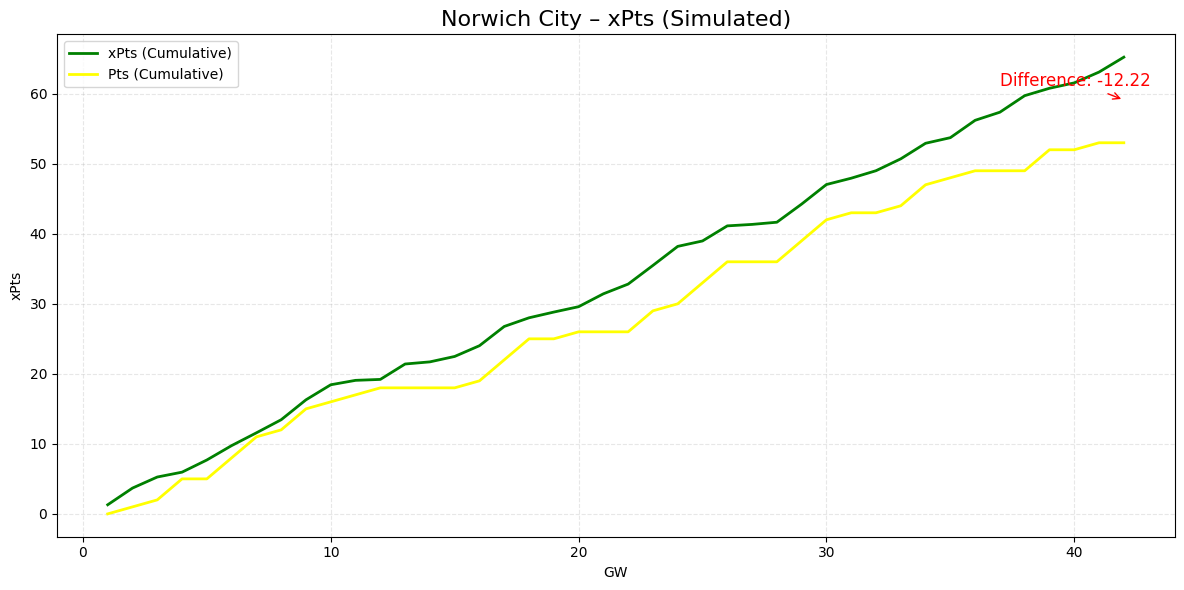

In [ ]:
# === Load JPEG or PNG logo ===
logo_path = r"C:\Users\44773\Documents\Norwich_City_FC_logo.jpeg"
logo_img = Image.open(logo_path)  # Resize as needed

# Add the logo at the final point
x_last = df['GW'].iloc[-1]
y_last = df['xPts_cumulative'].iloc[-1]

# imgbox = OffsetImage(logo_img, zoom=0.05)
# ab = AnnotationBbox(imgbox, (x_last, y_last), frameon=False)
# plt.gca().add_artist(ab)
# === Plotting ===
plt.figure(figsize=(12, 6))
plt.plot(df['GW'], df['xPts_cumulative'], color='green', linewidth=2, label='xPts (Cumulative)')
plt.plot(df['GW'], df['Pts_cumulative'], color='yellow', linewidth=2, label='Pts (Cumulative)')

# Get the final gameweek index
last_gw = df['GW'].iloc[-1]
final_xpts = df['xPts_cumulative'].iloc[-1]
final_pts = df['Pts_cumulative'].iloc[-1]
diff = final_pts - final_xpts

# Annotate the difference
plt.annotate(f"Difference: {diff:.2f}",
             xy=(last_gw, (final_xpts + final_pts) / 2),
             xytext=(last_gw - 5, (final_xpts + final_pts) / 2 + 2),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=12,
             color='red')

# Final styling
plt.title("Norwich City – xPts (Simulated)", fontsize=16)
plt.xlabel("GW")
plt.ylabel("xPts")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()


In [41]:
save_path = "norwich_xpts.gif"
frames = []

for i in range(1, len(df) + 1):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Line up to current matchweek
    ax.plot(df['GW'][:i], df['xPts_cumulative'][:i], color='green', linewidth=2, label='xPts (Cumulative)')

    # Optional: Actual points
    # ax.plot(df['GW'][:i], df['actual_pts_cumulative'][:i], color='gold', linestyle='--', label='Actual')

    # Add logo on final frame
    if i == len(df):
        x_last = df['GW'].iloc[i - 1]
        y_last = df['xPts_cumulative'].iloc[i - 1]
        imgbox = OffsetImage(logo_img, zoom=0.08)
        ab = AnnotationBbox(imgbox, (x_last, y_last), frameon=False)
        ax.add_artist(ab)

    # Styling
    ax.set_xlim(0, len(df) + 1)
    ax.set_ylim(0, df['xPts_cumulative'].max() + 3)
    ax.set_xlabel("Gameweek")
    ax.set_ylabel("Cumulative xPts")
    ax.set_title("Norwich City – Simulated xPts Progression", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Optional: Add legend on final frame
    # if i == len(df):
    #     ax.legend()

    # Convert to image using RGBA-safe method
    fig.canvas.draw()
    image_array = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    image_array = image_array.reshape((h, w, 4))
    frame = Image.fromarray(image_array[..., :3])  # Strip alpha for GIF
    frames.append(frame)

    plt.close(fig)

# === Add pause on last frame ===
for _ in range(10):  # Hold on the final frame
    frames.append(frames[-1])

# === Save as GIF ===
frames[0].save(
    save_path,
    format='GIF',
    save_all=True,
    append_images=frames[1:],
    duration=150,  # ms per frame
    loop=0
)

print(f"✅ GIF saved to: {save_path}")

✅ GIF saved to: norwich_xpts.gif


In [44]:
save_path = "norwich_xpts_smooth.gif"

# === Interpolate for smooth frames ===
interp_steps = 10  # how many in-between frames per gameweek
frames = []

x_interp = []
y_interp = []

for i in range(1, len(df)):
    x_start, x_end = df['GW'].iloc[i-1], df['GW'].iloc[i]
    y_start, y_end = df['xPts_cumulative'].iloc[i-1], df['xPts_cumulative'].iloc[i]
    
    # Interpolate between this and next point
    x_vals = np.linspace(x_start, x_end, interp_steps)
    y_vals = np.linspace(y_start, y_end, interp_steps)

    for x, y in zip(x_vals, y_vals):
        x_interp.append(x)
        y_interp.append(y)

# Add final point (exact)
x_interp.append(df['GW'].iloc[-1])
y_interp.append(df['xPts_cumulative'].iloc[-1])

# === Generate frames ===
for i in range(1, len(x_interp) + 1):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot smooth line
    ax.plot(x_interp[:i], y_interp[:i], color='green', linewidth=2)

    # Add logo only on last frame
    if i == len(x_interp):
        x_last, y_last = x_interp[-1], y_interp[-1]
        imgbox = OffsetImage(logo_img, zoom=0.04)
        ab = AnnotationBbox(imgbox, (x_last, y_last), frameon=False)
        ax.add_artist(ab)

    # Styling
    ax.set_xlim(0, df['GW'].iloc[-1] + 1)
    ax.set_ylim(0, df['xPts_cumulative'].max() + 3)
    ax.set_xlabel("Gameweek")
    ax.set_ylabel("Cumulative xPts")
    ax.set_title("Norwich City – Simulated xPts Progression", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Convert to image
    fig.canvas.draw()
    image_array = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    image_array = image_array.reshape((h, w, 4))
    frame = Image.fromarray(image_array[..., :3])
    frames.append(frame)
    plt.close(fig)

# === Add pause at final frame ===
for _ in range(12):
    frames.append(frames[-1])

# === Save GIF ===
frames[0].save(
    save_path,
    format='GIF',
    save_all=True,
    append_images=frames[1:],
    duration=80,  # smoother = quicker frame updates
    loop=0
)

print(f"✅ Smooth GIF saved to: {save_path}")


✅ Smooth GIF saved to: norwich_xpts_smooth.gif
